## Applying XceptionNet on New Data (Front Facing Image Data)

Here we import the pre-processed new data then test the accuracies using 2 variation of epochs i.e. 3,15 similar to the process of original work.

Importing Required Libraries

In [1]:
import keras
import tensorflow as tf
from keras import layers,Model
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout,InputLayer,Flatten,Dense,BatchNormalization,MaxPooling2D,Conv2D,Input,Concatenate,LeakyReLU
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical,normalize
from keras.applications.xception import Xception,preprocess_input
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint,TensorBoard
import numpy as np
import joblib
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm_notebook as tqdm
import warnings
import keras.backend as K
import random
warnings.filterwarnings('ignore')

Mounting Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading Pickled files from previous stage i.e., Data Pre-processing

(To load the pickled files you need to right click on given drive link folder and choose the option to add it to my drive)

Drive Link : https://drive.google.com/drive/folders/1wR35sieyxo9v1QWws61_kQeOahCluB1t?usp=sharing

In [4]:
#Loading already preprocessed files.
x_test=joblib.load('/content/drive/My Drive/Pre-Processed Data/Sai Frontface data/x_test.pkl')
x_train=joblib.load('/content/drive/My Drive/Pre-Processed Data/Sai Frontface data/x_train.pkl')
y_test=joblib.load('/content/drive/My Drive/Pre-Processed Data/Sai Frontface data/y_test.pkl')
y_train=joblib.load('/content/drive/My Drive/Pre-Processed Data/Sai Frontface data/y_train.pkl')
y_cv=joblib.load('/content/drive/My Drive/Pre-Processed Data/Sai Frontface data/y_cv.pkl')
x_cv=joblib.load('/content/drive/My Drive/Pre-Processed Data/Sai Frontface data/x_cv.pkl')

Shape of Train, validation and test data

In [5]:
print("Shape of Train data {}".format(x_train.shape))
print("Shape of Cv data {}".format(x_cv.shape))
print("Shape of Test data {}".format(x_test.shape))

Shape of Train data (6060, 299, 299, 3)
Shape of Cv data (606, 299, 299, 3)
Shape of Test data (3434, 299, 299, 3)


Converting Y set into categorical

In [6]:
Y_train=to_categorical(y_train)
Y_test = to_categorical(y_test)
Y_cv = to_categorical(y_cv)

Xception Network (Diagram shown below is an architecture of Xceptionet followd in the research paper)

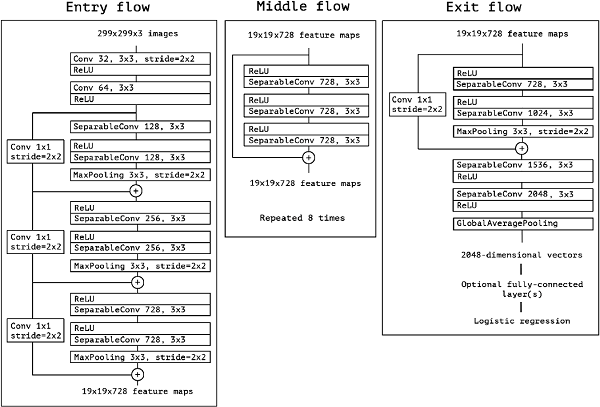

Greedy Layer-Wise Pretraining Learned from : https://machinelearningmastery.com/greedy-layer-wise-pretraining-tutorial/

1. Pre-training the network with train data on initilizing the "imagenet" weights with "include_top=False"

2. After training 3 epochs remove the top most layer

3. Now add similar top layer and again train and validate

XceptionNet [1] is a traditional CNN trained on ImageNet
based on separable convolutions with residual connections.
We transfer it to our task by replacing the final
fully connected layer with two outputs. The other layers are
initialized with the ImageNet weights. To set up the newly
inserted fully connected layer, we fix all weights up to the final
layers and pre-train the network for 3 epochs. 

[1] https://bit.ly/3jUuZKU

In [7]:

Xception_initial=Xception(include_top=False,
                 weights='imagenet',
                 input_shape=(299,299,3),pooling ='avg',
                 )
#print(Xception_pre_trained.summary())

for layer in Xception_initial.layers:
    layer.trainable = True

x = Xception_initial.output
predicted = Dense(2,activation ='softmax')(x)
model_pretrain = Model(Xception_initial.input, predicted)
model_pretrain.compile(loss=keras.losses.categorical_crossentropy,
          optimizer=keras.optimizers.Adam(lr = 0.0002),
          metrics=['accuracy'])
pretraining_Xception =model_pretrain.fit(x_train, Y_train,
                                              verbose=1,
                                              batch_size=32,  
                                              epochs=3)

83689472/83683744 [==============================] - 2s 0us/step
Epoch 1/3
190/190 [==============================] - 135s 710ms/step - loss: 0.0630 - accuracy: 0.9731
Epoch 2/3
190/190 [==============================] - 135s 712ms/step - loss: 0.0038 - accuracy: 0.9988
Epoch 3/3
190/190 [==============================] - 135s 711ms/step - loss: 2.1743e-04 - accuracy: 1.0000


Similar to authors approach, removing topmost layer and Now, we train the network for 15 more epochs and choose the best performing model based on validation accuracy.

In [8]:
model_pretrain.layers.pop() 

In [9]:
tensorboard=TensorBoard(log_dir='./logs', histogram_freq=3)

In [10]:
for layer in model_pretrain.layers:
    layer.trainable = False
x = model_pretrain.output
#x= Dense(64,activation ='relu')(x)
#x = Dropout(0.2)(x)
#x= Dense(64,activation ='relu')(x)
#x = Dropout(0.2)(x)
#x= BatchNormalization()(x) 
predicted = Dense(2,activation ='softmax')(x)
model_finetune1 = Model(model_pretrain.input,predicted)
model_finetune1.compile(loss=keras.losses.categorical_crossentropy,
          optimizer=keras.optimizers.Adam(lr = 0.0002),
          metrics=['accuracy'])

finetuning1_XceptionNet=model_finetune1.fit(x_train, Y_train,verbose=1,batch_size=16,
                     epochs=15,validation_data=(x_cv, Y_cv)
                      ,callbacks=[tensorboard]
                     )

Epoch 1/15
  1/379 [..............................] - ETA: 0s - loss: 0.6626 - accuracy: 0.6875WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
379/379 [==============================] - 34s 90ms/step - loss: 0.6273 - accuracy: 0.6667 - val_loss: 0.7136 - val_accuracy: 0.5000
Epoch 2/15
379/379 [==============================] - 31s 83ms/step - loss: 0.5580 - accuracy: 0.6667 - val_loss: 0.7371 - val_accuracy: 0.5000
Epoch 3/15
379/379 [==============================] - 32s 83ms/step - loss: 0.4999 - accuracy: 0.6667 - val_loss: 0.7645 - val_accuracy: 0.5000
Epoch 4/15
379/379 [==============================] - 33s 87ms/step - loss: 0.4497 - accuracy: 0.9558 - val_loss: 0.7936 - val_accuracy: 0.5000
Epoch 5/15
379/379 [==============================] - 31s 83ms

Saving the model

In [11]:
model_finetune1.save("model_finetuned_xception.hdf5")

Evaluating on the training set

In [12]:
model_finetune1.evaluate(x_train,Y_train)

190/190 [==============================] - 26s 135ms/step - loss: 0.1408 - accuracy: 1.0000


[0.1407926082611084, 1.0]

Evaluating on the Validation set

In [13]:
model_finetune1.evaluate(x_cv,Y_cv)

19/19 [==============================] - 3s 144ms/step - loss: 1.1496 - accuracy: 0.5017


[1.1496483087539673, 0.5016501545906067]

Evaluating on the Unseen data

In [14]:
#Unseen data
model_finetune1.evaluate(x_test,Y_test)

108/108 [==============================] - 15s 136ms/step - loss: 1.0628 - accuracy: 0.5574


[1.062775731086731, 0.5573675036430359]

As expected, as the deepfakes created using First order motion model is giving a near perfect fakes makes it hard to detect, which is clearly one reason why the accuracy is low and also due its resolution being different from what the model is trained on . it is expected to work in the similar fashion